Installing necessary libraries

In [1]:
%pip install pandas
%pip install -U scikit-learn
%pip install fuzzywuzzy
%pip install fuzzywuzzy[speedup]
%pip install yellowbrick
%pip install seaborn
%pip install plotly.express
%pip install matplot
%pip install nbformat>=4.2.0
%pip install --upgrade nbformat

Importing necessary libraries

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from fuzzywuzzy import process
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

Importing the suitable dataset

In [3]:
spotify_data = pd.read_csv("genres_v2.csv", low_memory=False)
#using low_memory=False because they contain large data

In [4]:
print(spotify_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  type              42305 non-null  object 
 12  id                42305 non-null  object 
 13  uri               42305 non-null  object 
 14  track_href        42305 non-null  object 
 15  analysis_url      42305 non-null  object 
 16  duration_ms       42305 non-null  int64 

Feature Correlation

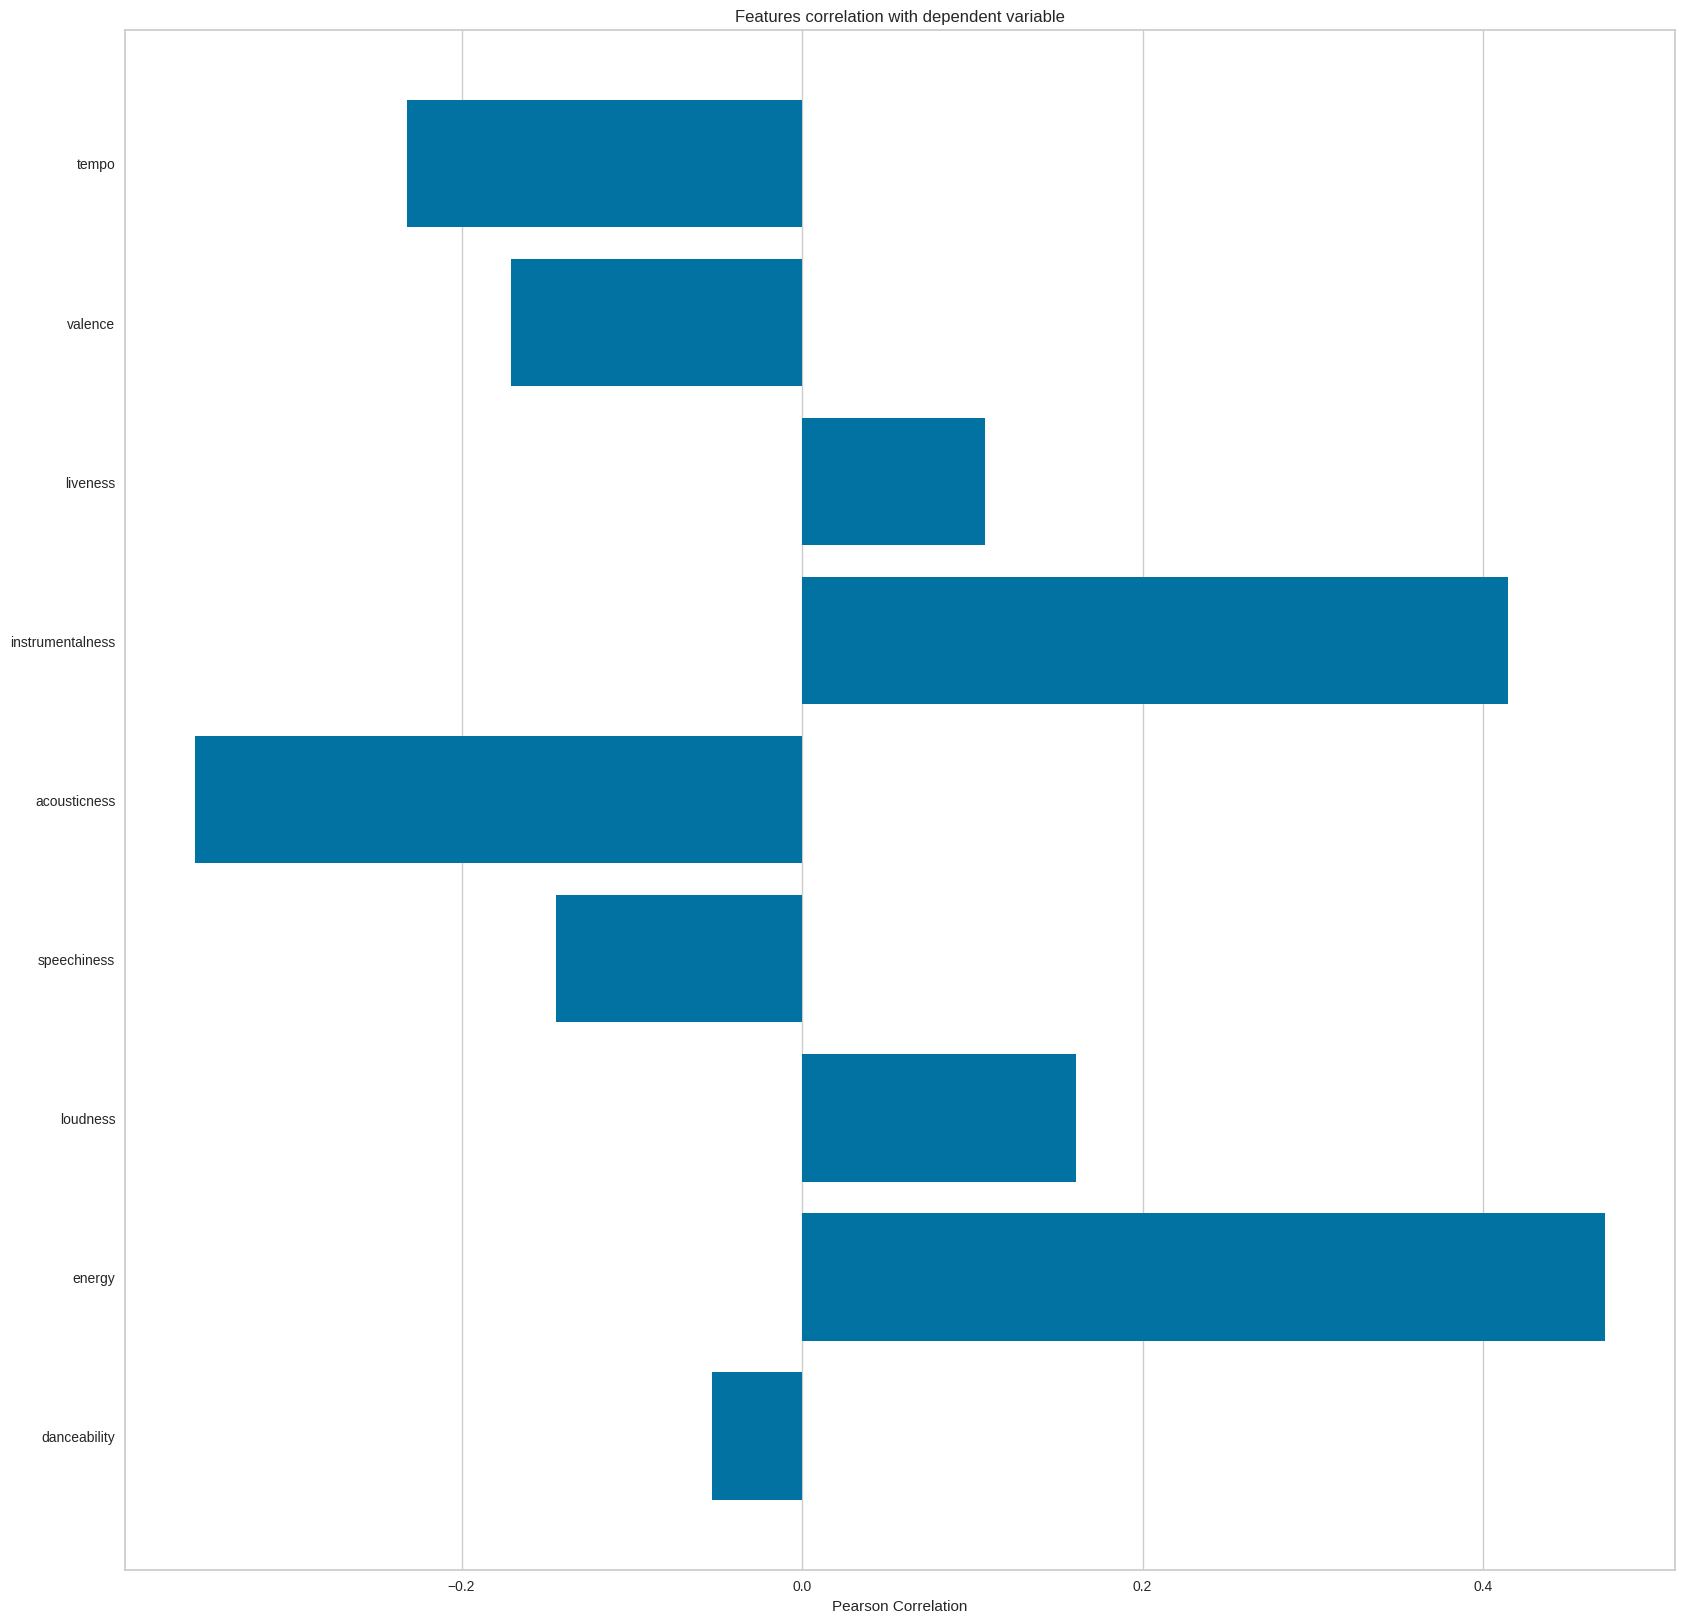

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [5]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'genre' column
spotify_data['genre_encoded'] = label_encoder.fit_transform(spotify_data['genre'])

# Use 'genre_encoded' as the target variable for correlation analysis
y = spotify_data['genre_encoded']

from yellowbrick.target import FeatureCorrelation

feature_names = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

y = spotify_data['genre_encoded']
x = spotify_data[feature_names]

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(x, y)     # Fit the data to the visualizer
visualizer.show()

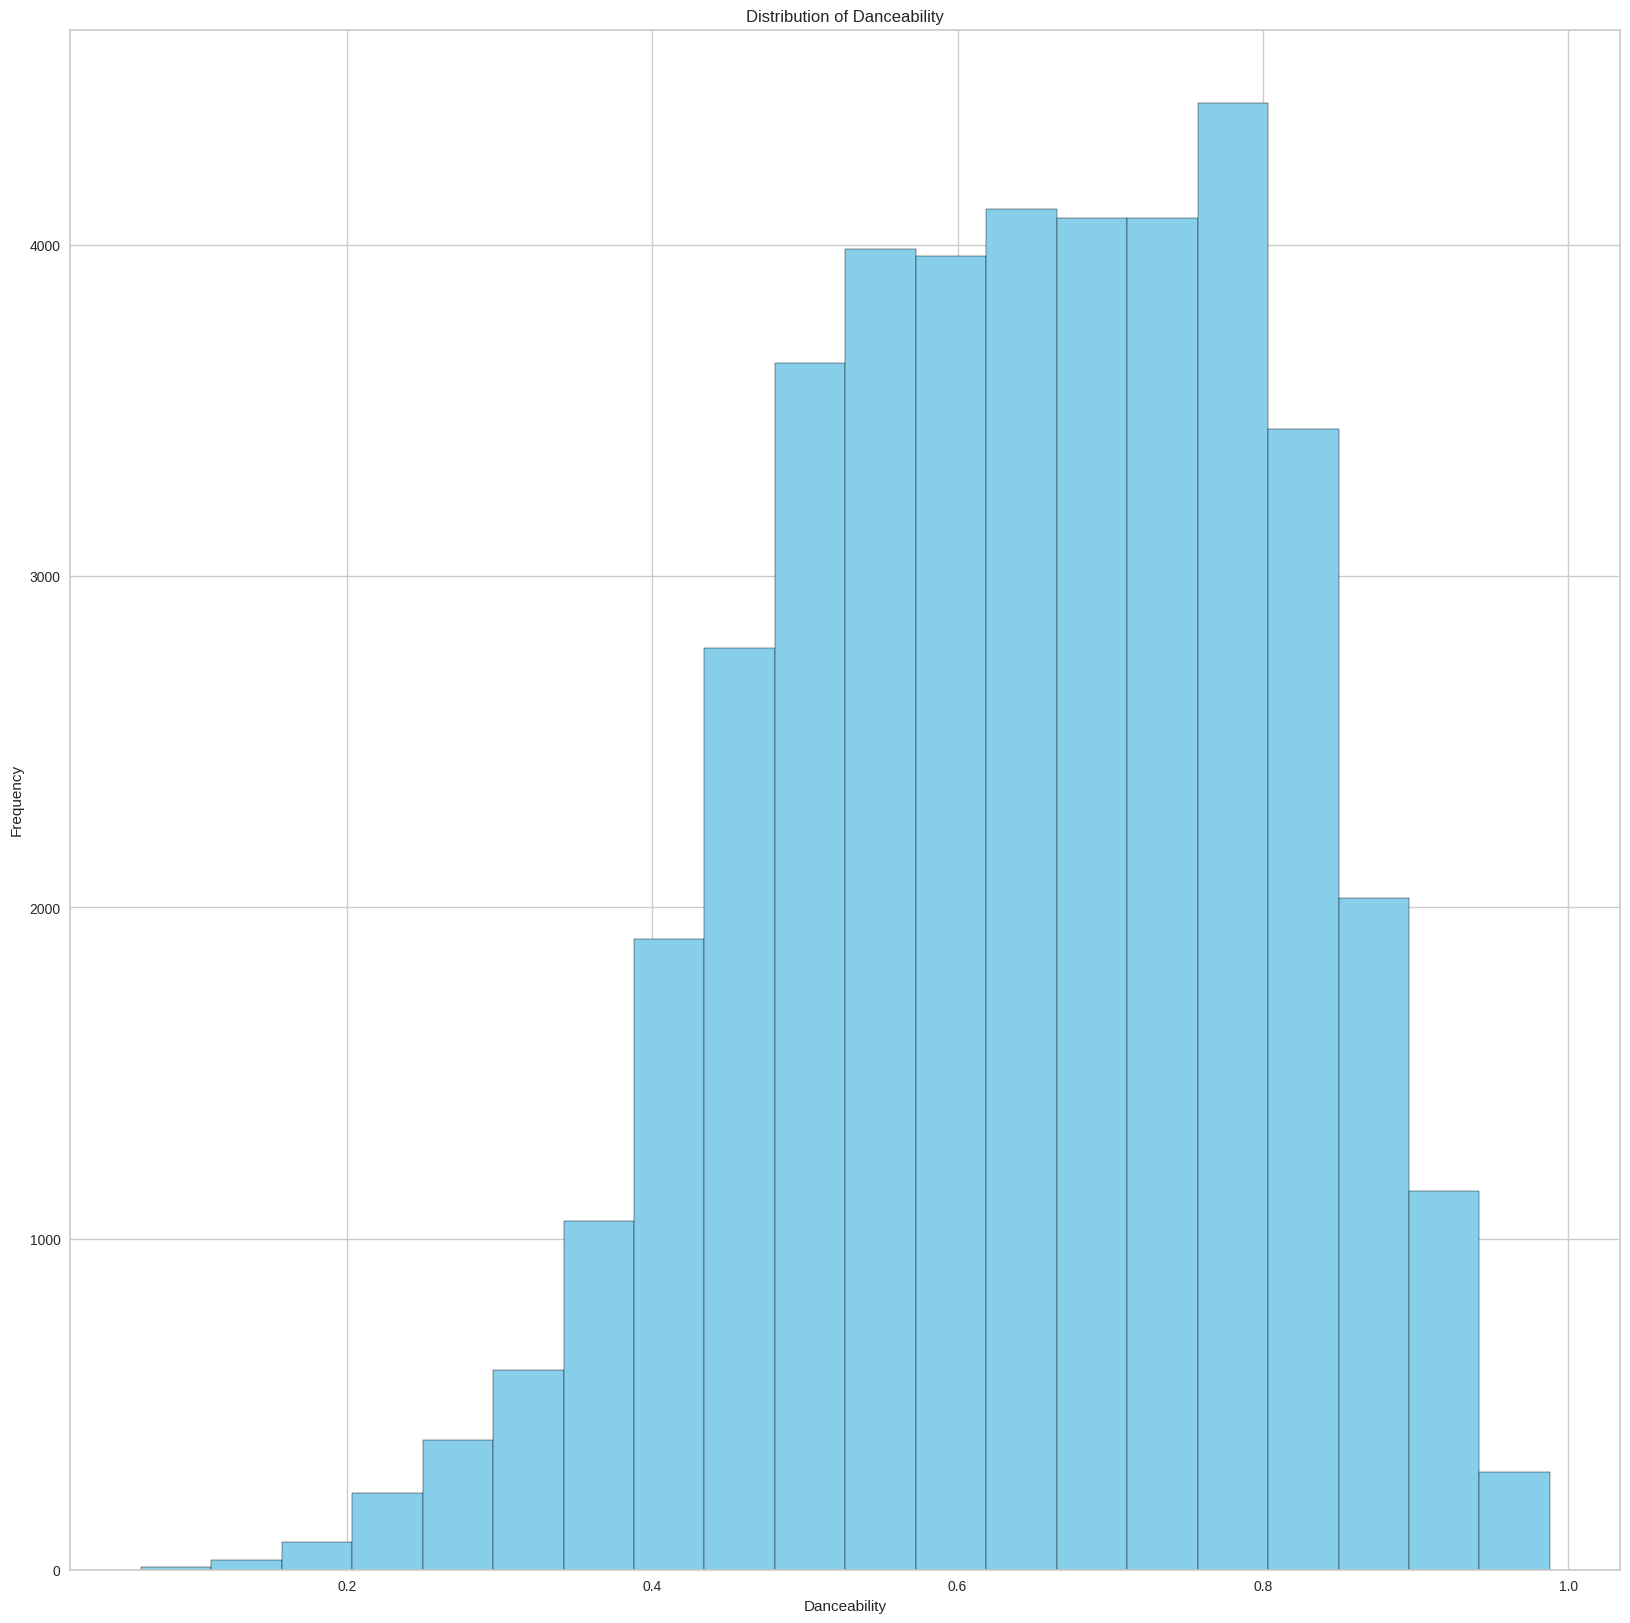

In [6]:
import matplotlib.pyplot as plt

# Plot a histogram of danceability
plt.hist(spotify_data['danceability'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Danceability')
plt.ylabel('Frequency')
plt.title('Distribution of Danceability')
plt.show()

Analysis Of Top Genre

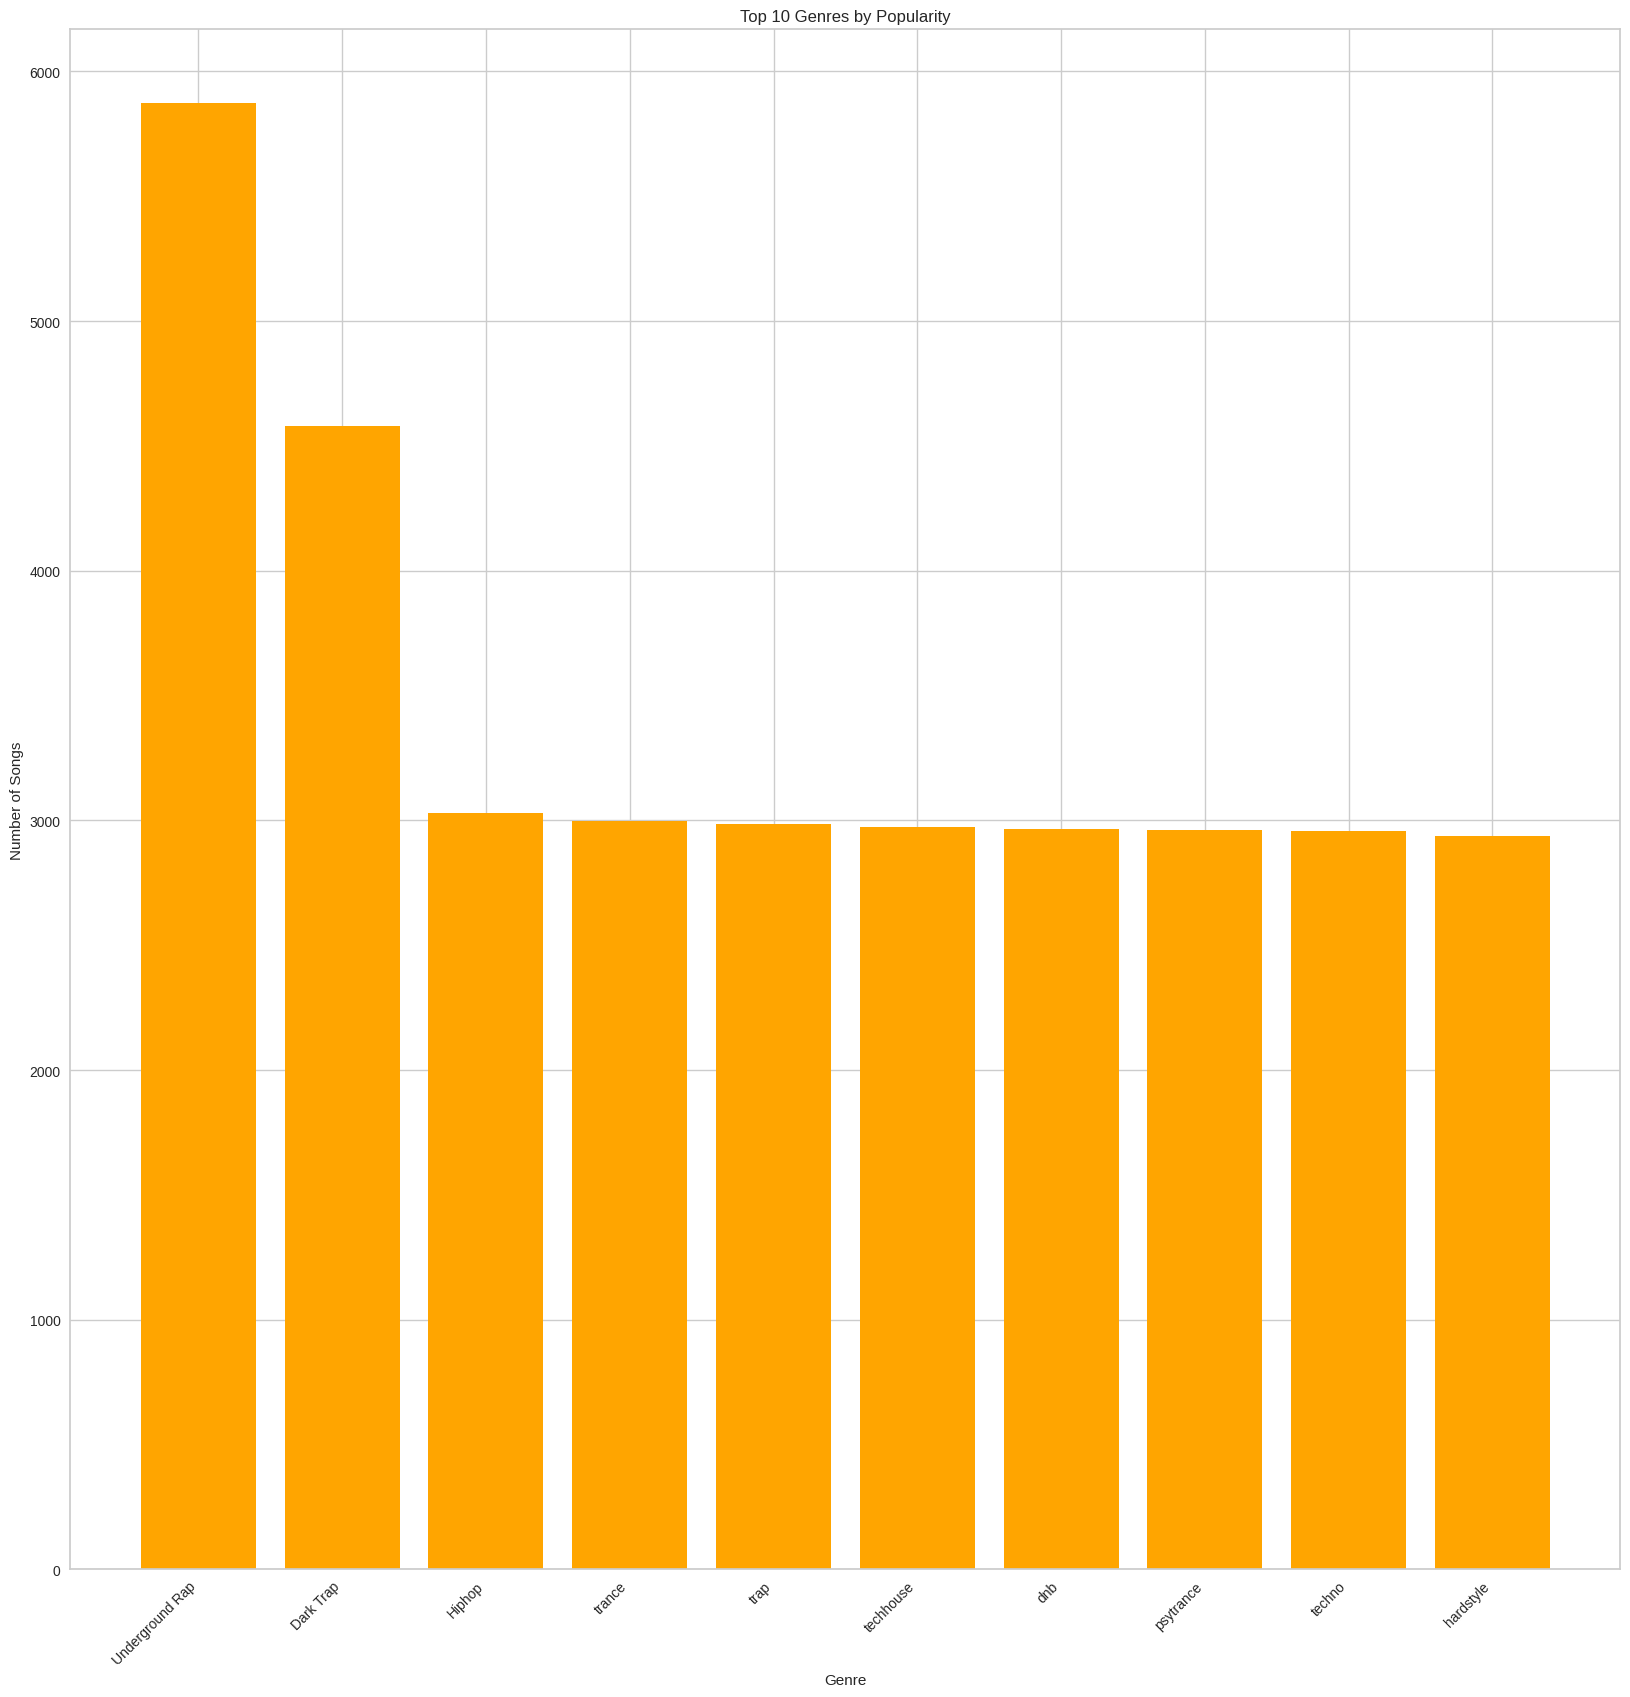

In [7]:
# Bar plot of top 10 genres by popularity
top_genres = spotify_data['genre'].value_counts().head(10)
plt.bar(top_genres.index, top_genres.values, color='orange')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Top 10 Genres by Popularity')
plt.xticks(rotation=45, ha='right')
plt.show()

Analysis of Danceability over Energy

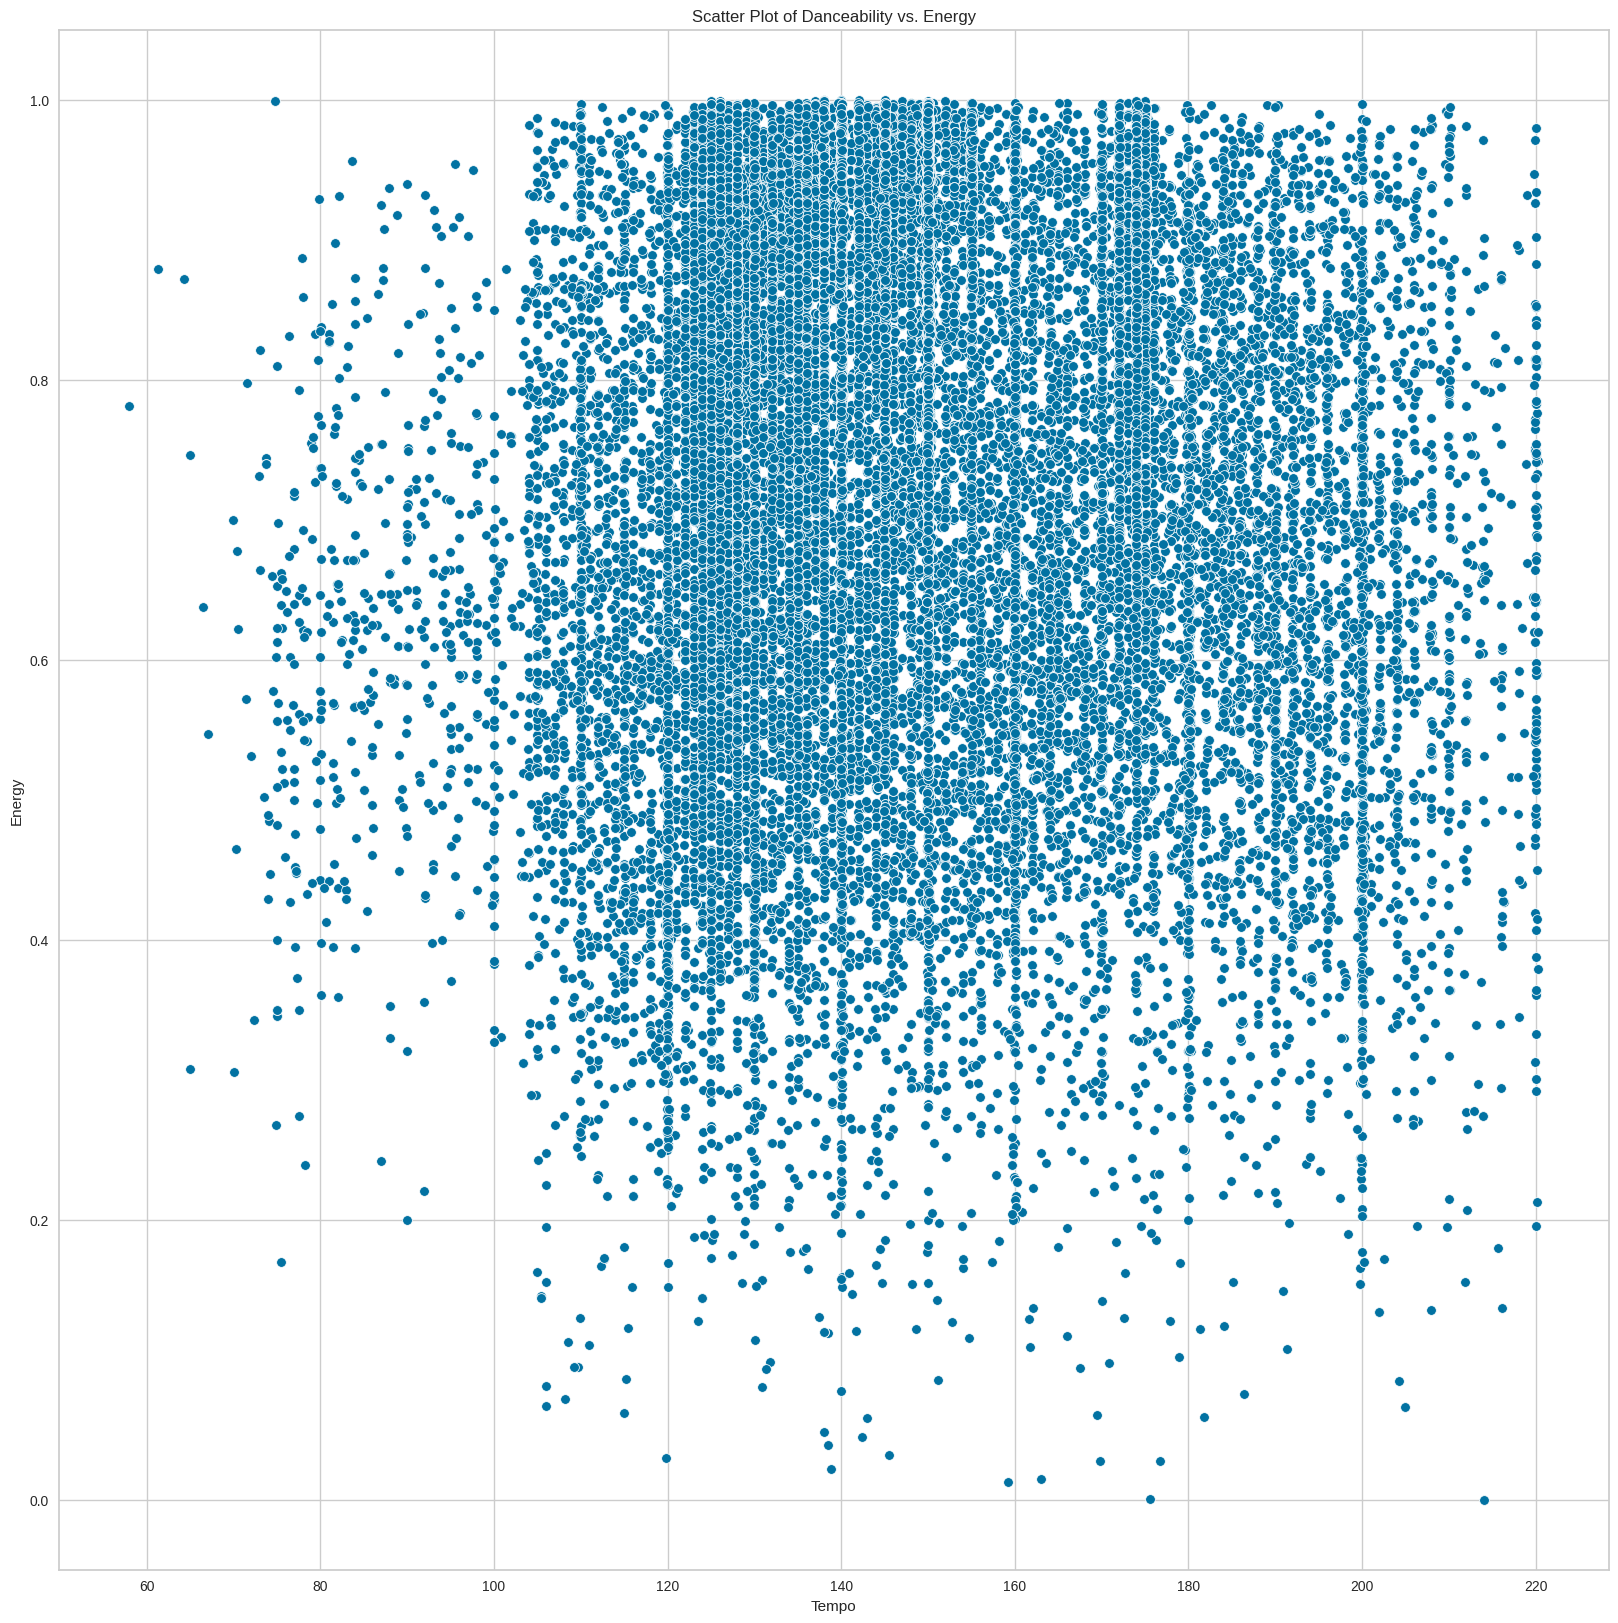

In [8]:
import seaborn as sns

# Scatter plot of danceability vs. energy
sns.scatterplot(x='tempo', y='energy', data=spotify_data)
plt.xlabel('Tempo')
plt.ylabel('Energy')
plt.title('Scatter Plot of Danceability vs. Energy')
plt.show()

Analysis of Loudness Over Acousticness

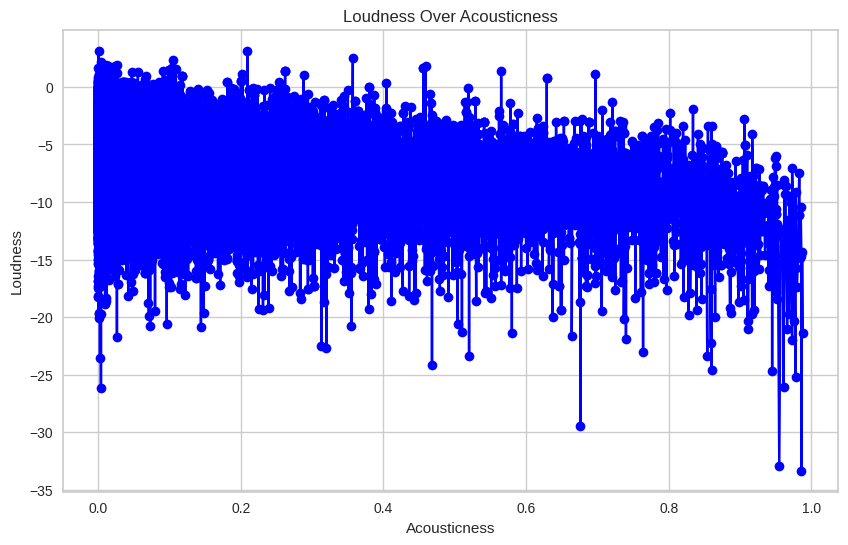

In [9]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'spotify_data' with columns 'release_date' and 'loudness'
# Convert 'release_date' column to datetime if it's not already in datetime format


# Sort the DataFrame by 'release_date' to ensure the data is plotted in chronological order
spotify_data = spotify_data.sort_values(by='acousticness')

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(spotify_data['acousticness'], spotify_data['loudness'], color='blue', marker='o', linestyle='-')
plt.title('Loudness Over Acousticness')
plt.xlabel('Acousticness')
plt.ylabel('Loudness')
plt.grid(True)
plt.show()


Defining the necessary data form dataset for the program

In [10]:
X = spotify_data[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

Displaying the complete output

In [11]:
pd.set_option('display.max_rows', None,
              'display.width', 9000)

Fitting K-Means clustering model and geting cluster model

In [12]:
# Fit K-Means clustering model
kmeans = KMeans(n_clusters=10, random_state=42)
# Convert DataFrame to numpy array
X_array = X.values

# Fit K-Means clustering model with numpy array
kmeans.fit(X_array)

# Get cluster labels
spotify_data['cluster'] = kmeans.labels_

Definign the function for recommended song from user input

In [13]:
# Define function to recommend songs based on user input
def recommend_songs(user_input, num_recommendations= 5, preferred_genre=None):
    user_cluster = kmeans.predict([user_input])[0]
    cluster_songs = spotify_data[spotify_data['cluster'] == user_cluster]
    if preferred_genre:
        cluster_songs = cluster_songs[cluster_songs['genre'].str.lower().str.contains(preferred_genre.lower())]
    recommendations = cluster_songs.sample(num_recommendations)
    #print(recommendations)-Dummycheck
    def merge_columns(row):
        if pd.isnull(row['song_name']):
            return row['title']
        else:
            return row['song_name']
    recommendations['merged_column']= recommendations.apply(merge_columns, axis=1)
    recommendations= recommendations.drop(columns=['song_name', 'title'])
    recommendations= recommendations.rename(columns={'merged_column':'Title of Track'})
    #print(recommendations)-dummycheck
    return recommendations[['Title of Track', 'genre', 'id']]

Defining a function to get features of user's favorite song

In [14]:
# Function to get features of user's favorite song
def get_favorite_song_features(song_name):
    # Filter out NaN values in the song_name column
    filtered_spotify_data = spotify_data.dropna(subset=['song_name'])
    song_name_lower = song_name.lower()
    matching_song = process.extractOne(song_name_lower, filtered_spotify_data['song_name'].str.lower())
    #print("Matching song:", matching_song)
    if matching_song and matching_song[1] >= 90:  # Adjust the threshold as needed
        song_features = filtered_spotify_data[filtered_spotify_data['song_name'].str.lower() == matching_song[0]]
        return song_features.iloc[0][['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
    else:
        print("Sorry, no similar song found in the dataset.")
        return None

Defining a function to get user input for preferred genre

In [15]:
# Function to get user input for preferred genre
def get_preferred_genre():
    while True:
        preferred_genre = input("Enter your preferred genre (or leave blank for any genre): ")
        if preferred_genre.strip() == "":
            return None
        else:
            return preferred_genre


Defining wokring main function to run the recommendation system

In [16]:
# Main function to run the recommendation system
def main():
    print("Welcome to the Spotify Music Recommendation System!")
    print("Please provide the name of your favorite song.")
    favorite_song = input("Favorite Song: ")
    favorite_song_features = get_favorite_song_features(favorite_song)
    if favorite_song_features is not None:
        preferred_genre = get_preferred_genre()
        num_recommendations = int(input("How many recommendations do you want? "))
        recommended_songs = recommend_songs(favorite_song_features.values.tolist(), num_recommendations, preferred_genre)
        print("\nRecommended Songs:")
        print(recommended_songs)

To make this program run

In [19]:
if __name__ == "__main__":
    main()

Welcome to the Spotify Music Recommendation System!
Please provide the name of your favorite song.
Favorite Song: die for you
Enter your preferred genre (or leave blank for any genre): underground rap
How many recommendations do you want? 15

Recommended Songs:
                      Title of Track            genre                      id
7252    Babylon (feat. Denzel Curry)  Underground Rap  3Z3ANEnfT5iSJrNFJFHLQO
5029              Deep End Freestyle  Underground Rap  4zTPYAf5scZdp0LnwPPeWK
8844                        Opp Town  Underground Rap  7zZ6lGrn6T7ZTzuWuJrIvP
9005                     Elimination  Underground Rap  5wPhznwiMGc1tUojiEkAkG
8044                         Breathe  Underground Rap  3nl9QUuOHqDwFuqavpC7EB
6841  Running Back (feat. Lil Wayne)  Underground Rap  2h3i5tGUl6hMu572umjcGo
8173                     Tokyo Drift  Underground Rap  3si10s7dQ64XsH81PsGvNv
6375                             PvP  Underground Rap  4thqKBXNErzbgPJPCCahdZ
4914                       MARY JANE